#Feature extraction model with data augmentation layer for 10% of data of from Food101


In [1]:
#Getting/Downloading the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-02-19 10:50:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   145MB/s    in 1.1s    

2023-02-19 10:50:56 (145 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [66]:
#imports
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
#Unzipping the data
import zipfile

zip_ref = zipfile.ZipFile("/content/10_food_classes_10_percent.zip","r")
zip_ref.extractall("/content")
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/10_food_classes_10_percent.zip' mode='r'>>

In [4]:
#Creating directories
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [6]:
#Setup data inputs
IMG_SIZE = (224,224)

#Train data
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE)

#Test data
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:
#Building Data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name = "data_augmentaion")

#Input shape
input_shape = (224,224,3)

#Create a frozen base model
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

#Create input and output layers
inputs = Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name = "global_avg_pooling_2D_layer")(x)
outputs = Dense(10,activation = "softmax", name="output_layer")(x)
model = Model(inputs,outputs)

In [41]:
#EfficientNetB0 summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [14]:
#Compileing the model
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [40]:
#Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentaion (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_2D_layer  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [17]:
#Creating Modelcheckpoint callback
path = "/content/Checkpoint_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = path,
                                                                 save_weights_only = True,
                                                                 save_best_only = True,
                                                                 save_freq = "epoch",
                                                                 verbose = 1)

In [18]:
#Fitting the model
initial_epochs = 5

history_feature_extracted_model = model.fit(train_data,
                                            epochs = initial_epochs,
                                            validation_data=test_data,
                                            validation_steps = int(0.25*len(test_data)),
                                            callbacks=[checkpoint_callback]
                                            )

Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 1.8942 - accuracy: 0.4120
Epoch 1: val_loss improved from inf to 1.26663, saving model to /content/Checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 31s 695ms/step - loss: 1.8942 - accuracy: 0.4120 - val_loss: 1.2666 - val_accuracy: 0.7434
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.7480
Epoch 2: val_loss improved from 1.26663 to 0.86625, saving model to /content/Checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 13s 507ms/step - loss: 1.1481 - accuracy: 0.7480 - val_loss: 0.8663 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.8441 - accuracy: 0.8147
Epoch 3: val_loss improved from 0.86625 to 0.68859, saving model to /content/Checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 11s 432ms/step - loss: 0.8441 - accuracy: 0.8147 - val_loss: 0.6886 - val_accuracy: 0.8355
Epo

In [19]:
#Evaluate
result = model.evaluate(test_data)
result

79/79 [==============================] - 7s 81ms/step - loss: 0.5540 - accuracy: 0.8620


[0.5540462732315063, 0.8619999885559082]

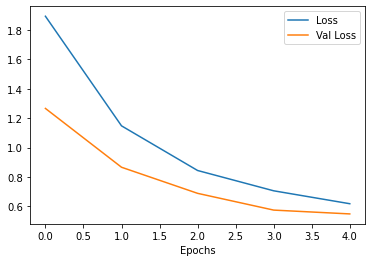

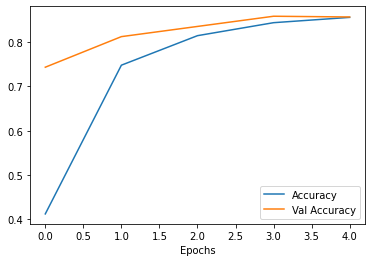

In [34]:
#Plot reults
plt.figure()
plt.plot(history_feature_extracted_model.history["loss"], label = "Loss")
plt.plot(history_feature_extracted_model.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs")
plt.legend()

plt.figure()
plt.plot(history_feature_extracted_model.history["accuracy"], label = "Accuracy")
plt.plot(history_feature_extracted_model.history["val_accuracy"], label = "Val Accuracy")
plt.xlabel("Epochs")
plt.legend();

#Fine Tunning the existing model with 100% data

In [35]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-02-19 11:48:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   240MB/s    in 2.1s    

2023-02-19 11:48:51 (240 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [36]:
#Unzipping the data
import zipfile

zip_ref_2 = zipfile.ZipFile("/content/10_food_classes_all_data.zip","r")
zip_ref_2.extractall("/content")
zip_ref_2.close()

In [44]:
#Setting up directories
train_data_all_dir = "/content/10_food_classes_all_data/train"
test_data_all_dir = "/content/10_food_classes_all_data/test"  #test data reamings thee same as previously used

In [47]:
#Creating training and test datasets
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_data_all_dir,
                                                                     label_mode = "categorical",
                                                                     image_size = IMG_SIZE)

test_data_all = tf.keras.preprocessing.image_dataset_from_directory(test_data_all_dir,
                                                                      label_mode = "categorical",
                                                                      image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


##Fine Tunning

In [48]:
#Setting base_model training as True
base_model.trainable = True

#Freezing all layers again except for last 10 layers
for layer in base_model.layers[:-10]:
  layer.traininable = False

In [49]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [50]:
#Recompilng the model since changes were made to the layer
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              metrics = ["accuracy"])

In [58]:
#fitting the model
fine_tune_epochs = initial_epochs + 5 
history = model.fit(train_data_all,
                    epochs = fine_tune_epochs,
                    validation_data = test_data_all,
                    initial_epoch=history_feature_extracted_model.epoch[-1],
                    validation_steps = int(0.25*len(test_data_all)),
                    callbacks=[checkpoint_callback])

Epoch 5/10


235/235 [==============================] - ETA: 0s - loss: 1.4792 - accuracy: 0.5009
Epoch 5: val_loss improved from 0.54851 to 0.52819, saving model to /content/Checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 236s 826ms/step - loss: 1.4792 - accuracy: 0.5009 - val_loss: 0.5282 - val_accuracy: 0.8174
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.7625
Epoch 6: val_loss improved from 0.52819 to 0.39323, saving model to /content/Checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 165s 699ms/step - loss: 0.7324 - accuracy: 0.7625 - val_loss: 0.3932 - val_accuracy: 0.8717
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.8436
Epoch 7: val_loss improved from 0.39323 to 0.34552, saving model to /content/Checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 144s 612ms/step - loss: 0.4918 - accuracy: 0.8436 - val_loss: 0.3455 - val

In [59]:
#Evaluate model
result_full_data = model.evaluate(test_data_all)
result_full_data

79/79 [==============================] - 6s 65ms/step - loss: 0.5143 - accuracy: 0.8428


[0.5143043398857117, 0.8428000211715698]

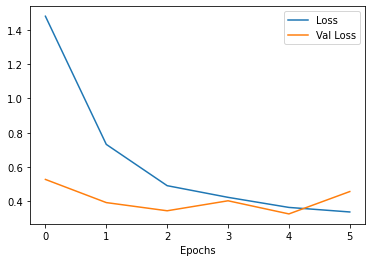

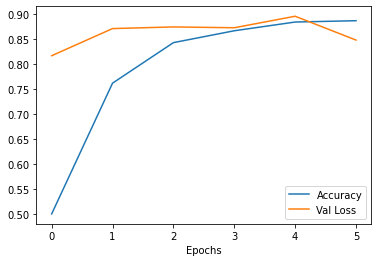

In [62]:
# Plot results
plt.figure()
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs")
plt.legend()

plt.figure()
plt.plot(history.history["accuracy"], label = "Accuracy")
plt.plot(history.history["val_accuracy"], label = "Val Loss")
plt.xlabel("Epochs")
plt.legend();

In [70]:
#Saving the model weights
model.save_weights('/content/model/food_classification_with_efficientnetb0_weights.h5')

In [71]:
#saving the model
tf.saved_model.save(model, "/content/model")